In [1]:
import pathlib
import functools
import datetime
import logging


import numpy as np

import pandas
import statsmodels.regression
import statsmodels.tsa.seasonal
import netCDF4
import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.geometry


import colorcet
import cmocean.cm

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# This notebook converts all the geojsons to csv files so we can concatenate and drop data we don't use

In [3]:
def feature2row(feature):
    """lookup relevant variables for a feature """
    change_rate = feature['properties'].get('change_rate')
    if change_rate == -999:
        change_rate = None
    
    row = {
        "lat": feature['properties']['transect_origin'][1],
        "lon": feature['properties']['transect_origin'][0],
        "sandy": feature['properties']['flag_sandy'],
        "rate": change_rate,
        "n_shorelines": feature['properties'].get('number_shorelines'),
    }
    return row

In [4]:
# This is the folder where I store all the geojsons
rates_path = pathlib.Path('/Users/baart_f/data/changerates')

In [5]:
# this takes a few minutes
recreate_json = False
if recreate_json:
    for i, path in tqdm.tqdm_notebook(list(enumerate(rates_path.glob('**/*.json')))):
        with path.open() as f:
            data = json.load(f)
            # extract rows
            rows = [feature2row(feature) for feature in data['features']]        
            # create table
            df = pandas.DataFrame.from_records(rows)
            # write
            df.to_csv(str(path.with_suffix('.csv')), header=i==0)

In [6]:
# After previous step, manual concatenate all csv files. Check if header is on the first file and then `cat **/*.csv > all_rates2.csv` 
df = pandas.read_csv('/Users/baart_f/data/changerates/all_rates2.csv')
# sandy_bool is 'True', 'False' or -999, cleanup in the generating routine...
df['sandy_bool'] = df['sandy'] == 'True'
# How many sandy transects do we have
df['sandy_bool'].sum()

646784

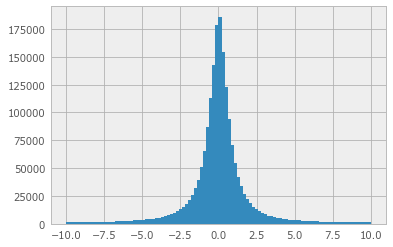

In [7]:
# We should have a nicely distributed figure here...
# It looks a bit double exponential, not sure why
plt.hist(df.rate.dropna(), range=(-10, 10), bins=100);

In [8]:
# compute the median erosion rate (just > 0)
df.rate.dropna().median(), df.rate.dropna().mean()

(0.028528117773860894, 0.15860411841970035)

In [9]:
# sea-level dataset from NASA (see openearth/sealevel/data/sat/Makefile for processing)
nc_path = pathlib.Path('~/src/sealevel/data/sat/dt_global_merged_msla_h_merged_nc4.nc').expanduser()
ds = netCDF4.Dataset(str(nc_path))

In [10]:
# just read the history into memory
sla = ds.variables['sla'][:]
# time, convert units
time = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
# location
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
# some convenience arrays for the regression
# compute days, seconds * (hours/second)  * (days / hour) -> days
days = np.array([t.timestamp() * 1/3600.0 * 1/24.0 for t in time]) 
# compute relative to first measurement
days = days - datetime.datetime(1970, 1, 1, 0, 0).timestamp()
years = days/365.25

In [11]:
# the STL expects a periodic variable
index = pandas.date_range(time[0], periods=len(time), freq='M')

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


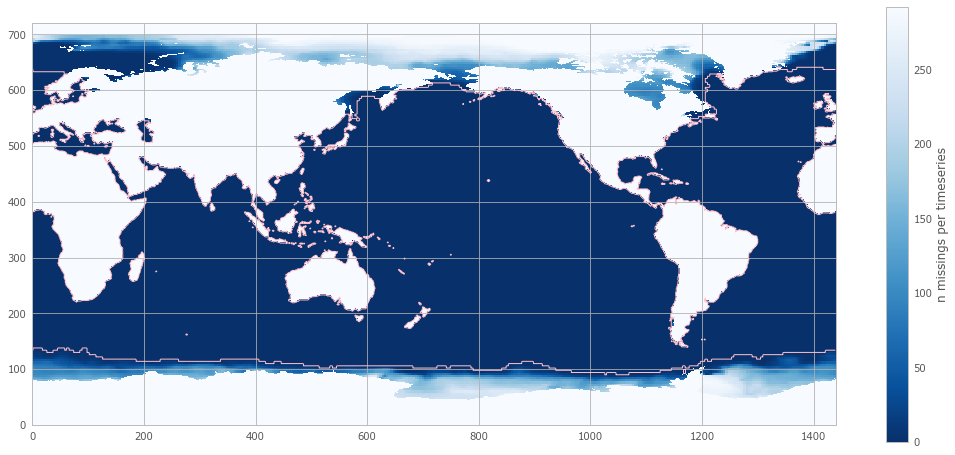

In [12]:
# show the results
fig, ax = plt.subplots(figsize=(18, 8))
# compute number of missings (mainly due to ice masking)
n_missing = sla.mask.sum(axis=0)
# show results
im = ax.imshow(n_missing, origin='top', cmap='Blues_r')
cb = plt.colorbar(im, ax=ax)
cb.set_label('n missings per timeseries')
# selection interval, contour does not support labelling
# TODO: erode by 1
ax.contour(n_missing, levels=[0], colors=['pink'])



In [13]:
# lookup corresponding index
# difference between lat (should be 0.25)
d_lat = (lat[-1] - lat[0])/(len(lat) - 1)
d_lon = (lon[-1] - lon[0])/(len(lon) - 1)
assert d_lat == 0.25
assert d_lon == 0.25
# transform lat and lons for each transect to index in sea-level map
i_idx = np.round((df.lat - lat[0])/d_lat).astype('int')
j_idx = np.round((np.mod(df.lon, 360) - lon[0])/d_lon).astype('int')
# store for each transect
df['i_idx'] = i_idx
df['j_idx'] = j_idx

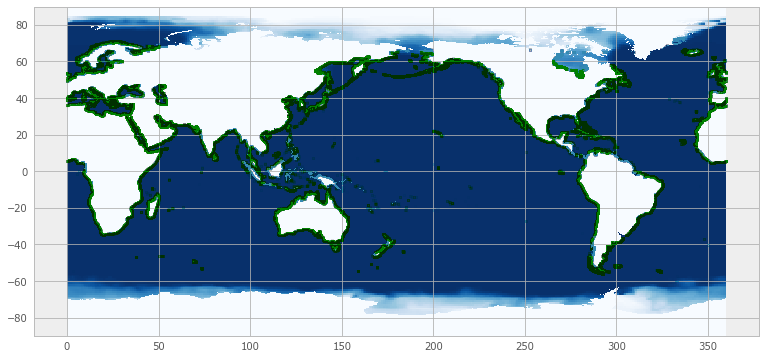

In [14]:
# show the sandy coasts and check lat/lon
fig, ax = plt.subplots(figsize=(13, 8))
n_missing = sla.mask.sum(axis=0)
im = ax.imshow(n_missing, origin='top', cmap='Blues_r', extent=(lon[0], lon[-1], lat[0], lat[-1]))
ax.plot(np.mod(df[df.sandy_bool].lon, 360), df[df.sandy_bool].lat, 'g.', alpha=0.005);
ax.plot(np.mod(df[~df.sandy_bool].lon, 360), df[~df.sandy_bool].lat, marker='.', markerfacecolor=(0.8, 0.8, 0.7), linestyle='None', alpha=0.005);


In [15]:
def ssh_for_idx(idx_i):
    """compute de-seasonalized sea-level trend for each index in lat and lon (denoted by idx_i (row, column))"""
    # lookup sea-level for index
    sla_i = sla[:, idx_i[0], idx_i[1]]
    # if data is missing, look a bit further (1 cell each direction) and take the mean
    if sla_i.mask.any() or np.isnan(sla_i).any():
        # try to look wider (mean of 3x3 window)
        sla_i = sla[:, (idx_i[0]-1):(idx_i[0]+1), (idx_i[1]-1):(idx_i[1]+1)]
        sla_i = sla_i.mean(axis=(1, 2))
        # if we still have missings, give up
        if sla_i.mask.any() or np.isnan(sla_i).any():
            return None

    # construct the time
    index = pandas.date_range(time[0], periods=len(time), freq='M')
    # compute a data frame
    ssh_df = pandas.DataFrame(index=index, data=dict(ssh=sla_i))
    # decompose the season
    model = statsmodels.tsa.seasonal.seasonal_decompose(ssh_df.ssh)
    # recompose leaving out the seasonal trend
    sla_no_season_i = model.trend + model.resid
    # filter nans (first half year of 1993 is missing)
    is_nan = np.isnan(sla_no_season_i)

    # fit the trend
    exog = statsmodels.regression.linear_model.add_constant(years)
    linear_model = statsmodels.regression.linear_model.OLS(sla_no_season_i[~is_nan], exog[~is_nan])

    # lookup sea-level rise
    fit = linear_model.fit()
    const, trend = fit.params
    return trend

In [16]:
# lookup the unique transects where we need the sea-level rise
work = df[['i_idx', 'j_idx']]
unique_work = work.drop_duplicates().copy()


In [17]:
# compute all the trends (takes a few minutes for only coastal locations, 
# an hour or 10 for all the sea-level rise locations)
# TODO: find a more efficient way or run in parallel
trends = []
for i, row in tqdm.tqdm_notebook(unique_work.iterrows()):
    trend = ssh_for_idx(tuple(row))
    trends.append(trend)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [18]:
# store trends per unique location
unique_work['trends'] = trends

In [19]:
# merge back with locations
merged = pandas.merge(df, unique_work, left_on=['i_idx', 'j_idx'], right_on=['i_idx', 'j_idx'], how='inner')

In [20]:
# save results
merged[['lat', 'lon', 'n_shorelines', 'rate', 'trends', 'sandy_bool', 'i_idx', 'j_idx']].to_csv('trends.csv')


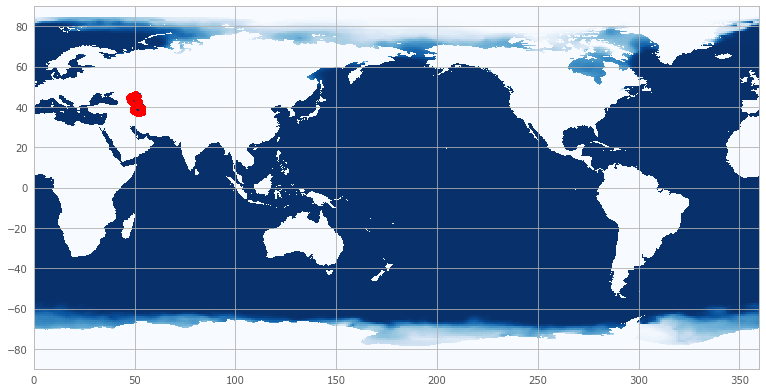

In [21]:
# show the locations more extreme sea-level trends
fig, ax = plt.subplots(figsize=(13, 8))
strange = merged[merged['trends'] < -0.04]
im = ax.imshow(n_missing, origin='top', cmap='Blues_r', extent=(lon[0], lon[-1], lat[0], lat[-1]))
ax.plot(np.mod(strange.lon, 360), strange.lat, 'r.', alpha=1);



In [22]:
# double check if we got our trends from the correct location
merged['lon_lookup'] = lon[merged['j_idx']]
merged['lat_lookup'] = lat[merged['i_idx']]
merged.head()

,Unnamed: 0,lat,lon,n_shorelines,rate,sandy,sandy_bool,i_idx,j_idx,trends,lon_lookup,lat_lookup
0,0,-58.488625,-26.382632,0,NaN,True,True,126,1334,0.002468,333.625,-58.375
1,1,-58.489830,-26.378777,0,NaN,-999.0,False,126,1334,0.002468,333.625,-58.375
2,2,-58.491034,-26.374921,0,NaN,-999.0,False,126,1334,0.002468,333.625,-58.375
3,3,-58.492238,-26.371065,0,NaN,-999.0,False,126,1334,0.002468,333.625,-58.375
4,4,-58.493442,-26.367210,0,NaN,-999.0,False,126,1334,0.002468,333.625,-58.375


In [23]:
# also compute a ordinary linear regression (with seasons) so we can make a map (without waiting 10 hours)
exog = statsmodels.regression.linear_model.add_constant(years)
def linear_ssh_for_idx(idx_i):
    """use linear trend"""
    sla_i = sla[:, idx_i[0], idx_i[1]]
    if sla_i.mask.sum() > 10:
        return None

    # fit the trend
    
    try:
        linear_model = statsmodels.regression.linear_model.OLS(sla_i, exog)
    except:
        logging.exception('failed at %s', idx_i)
        raise

    fit = linear_model.fit()
    const, trend = fit.params
    return trend

In [24]:
# runs for 3 min or so
trends = np.ma.masked_all_like(sla.mean(axis=0))
for idx in tqdm.tqdm_notebook(np.ndindex(trends.shape)):
    trends[idx] = linear_ssh_for_idx(idx)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [25]:
# lookup global average trend so we can compute trend anomalies
# trend (not correcting for seasonal effect)
linear_model = statsmodels.regression.linear_model.OLS(sla.mean(axis=(1, 2)) * 1000, exog)
fit = linear_model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     2911.
Date:                Sat, 09 Dec 2017   Prob (F-statistic):          3.00e-153
Time:                        15:59:28   Log-Likelihood:                -964.19
No. Observations:                 292   AIC:                             1932.
Df Residuals:                     290   BIC:                             1940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -100.9580      2.504    -40.321      0.000    -105.886     -96.030
x1             2.9649      0.055     53.952      0.000       2.857       3.073
==============================================================================
Omnibus:                       11.153   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.779
Skew:                           0.209   Prob(JB):                       0.0337
Kurtosis:                       2.382   Cond. No.                         296.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

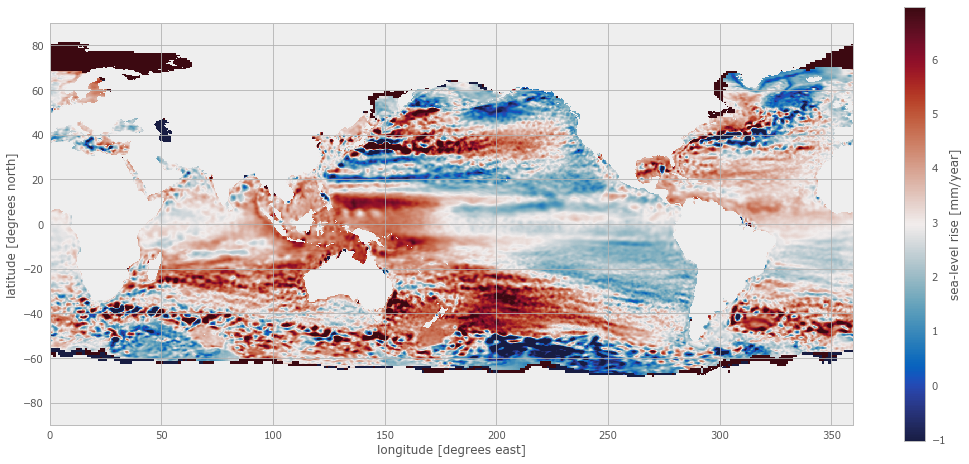

In [26]:
# show trend anomalies in color and trend
fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(
    trends * 1000, origin='top', 
    vmin=fit.params[1] - 4, 
    vmax=fit.params[1] + 4, 
    cmap=cmocean.cm.balance, 
    extent=(lon[0], lon[-1], lat[0], lat[-1])
)
cb = plt.colorbar(im, ax=ax)
ax.set_xlabel('longitude [degrees east]')
ax.set_ylabel('latitude [degrees north]')
cb.set_label('sea-level rise [mm/year]')